## Adaptive Sampling Algorithm Using Pentapeptide Molecule Trajectory Data 
### Pentapeptides are small protein fragments consisting of five amino acids. This trajectory contains 1,25,025 frames.

#### Importing necessary libraries.

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import mdshare
import pyemma
from pyemma.util.contexts import settings
from sklearn.cluster import KMeans 
import math
import mdtraj as md
import warnings
warnings. filterwarnings('ignore') 

### Data input and Featurization.

#### Loading Data

In [2]:
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data') 
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

#### Featurization 
##### In this tutorial we have consider backbone torsion angle as a feature. 

In [3]:
torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

Obtaining file info:   0%|                                                                      | 0/25 [00:00<…

getting output of FeatureReader:   0%|                                                          | 0/25 [00:00<…

##### We are taking a TICA projection with lag time 0.5 ns (5 steps).

In [27]:
tica = pyemma.coordinates.tica(torsions_data, lag=5)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

calculate covariances:   0%|                                                                    | 0/25 [00:00<…

getting output of TICA:   0%|                                                                   | 0/25 [00:00<…

#### Following code gives the optimal number of clusters based on VAMP-2 score. The point of saturation and corresponding cluster number on x-axis taken as initial number of clusters. 

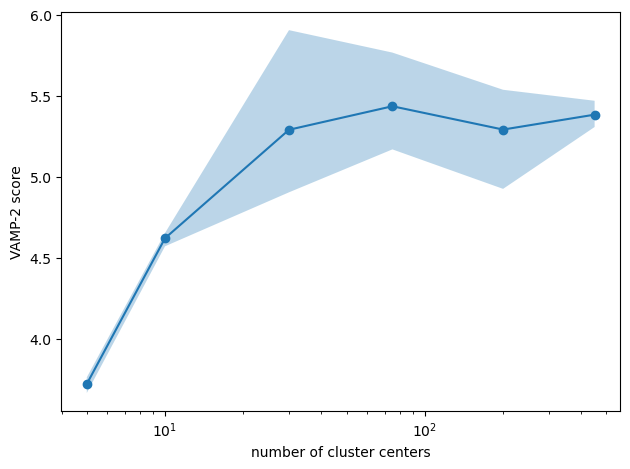

In [8]:
n_clustercenters = [5, 10, 30, 75, 200, 450]

scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=50, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

In [9]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=80, max_iter=50, stride=10, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

initialize kmeans++ centers:   0%|                                                              | 0/80 [00:00<…

kmeans iterations:   0%|                                                                        | 0/50 [00:00<…

getting output of KmeansClustering:   0%|                                                       | 0/25 [00:00<…

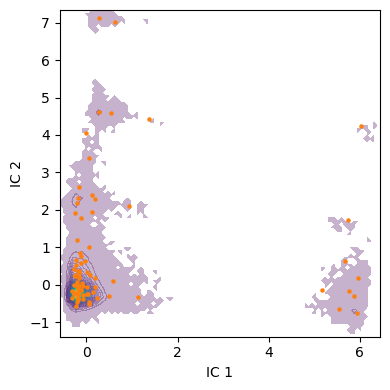

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()

#### From here on adaptive sampling method starts. We perform certain steps again to insure further script to work properly.

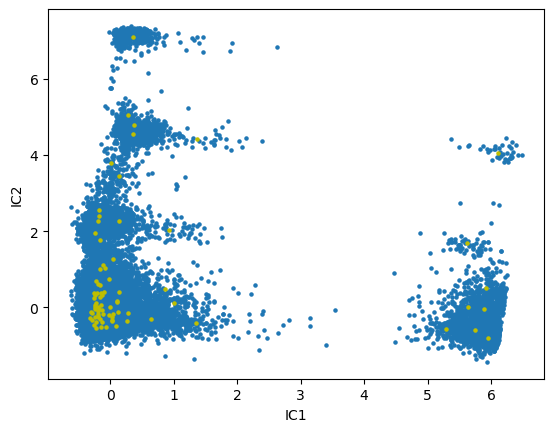

In [12]:
# this code requires input as tica co-ordinates and number of clusters, initialize them as tica_concatenated
number_of_clusters = 80 #Replace this number by cluster count provided by VAMP-2 score vs number of cluster plot. 
df1 = pd.DataFrame(tica_concatenated)
X = df1.iloc[:,:].values
km = KMeans(n_clusters=number_of_clusters) 
membership = km.fit_predict(X)
plt.scatter(X[:,0],X[:,1],s=5)
plt.xlabel('IC1')
plt.ylabel('IC2')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='y',s=5)
plt.show()

#### Following code will extract cluster centroids. To obtain optimal number of cluster to devide these centroids further elbow method is used. Here our attempt is to identify outlier clusters.   

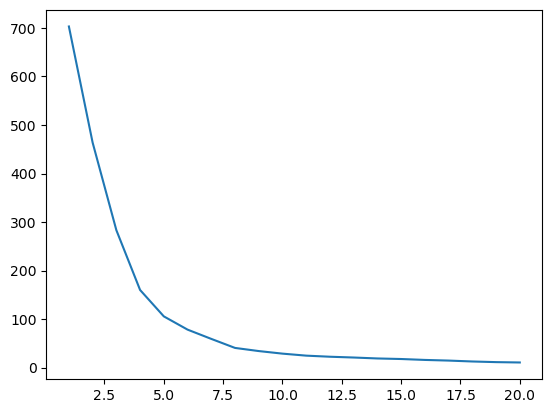

In [13]:
df2 = pd.DataFrame(km.cluster_centers_)
wcss = []
for i in range(1,21):
    kmm = KMeans(n_clusters=i)
    kmm.fit_predict(df2)
    wcss.append(kmm.inertia_)

plt.plot(range(1,21),wcss)

#### Based on elbow plot we decide to take numebr of cluster= 7. This will divide intial 80 centroids into 7 difeerent clusters

In [14]:
cluster_numbers = 7
Y = df2.iloc[:,:].values
km = KMeans(n_clusters=cluster_numbers)
c_membership = km.fit_predict(Y)

#### Following code is the adaptive sampling method that will give the outlier data points.

In [16]:
cluster_index = list(set(c_membership))
frame_tica = []
for i in cluster_index:
    cen = Y[c_membership==i]
    if len(cen) != 1:
        dist_cen = []
        for j in range(len(cen)):
            dist_cen.insert(j,math.dist([cen[j,0],cen[j,1]],[np.mean(cen[:,0]),np.mean(cen[:,1])]))
        dist_cen_sorted = np.sort(dist_cen)[::-1]
        cut = dist_cen_sorted[0]/2
        cen_index= []
        for i in dist_cen:
            if i>cut:
                cen_index.append(dist_cen.index(i))
        
        for j in cen_index:
            arr = cen[j]
            index=np.where(Y==arr)[0][0]
            clt1 = X[membership==index]
            dist_clt1 = []
            for i in range(len(clt1)):
                dist_clt1.insert(i,math.dist([clt1[i,0],clt1[i,1]],[np.mean(clt1[:,0]),np.mean(clt1[:,1])]))
                dist_clt1_sorted = np.sort(dist_clt1)[::-1]
                cutoff = dist_clt1_sorted[0]/2
                clt1_index = []
                for i in dist_clt1_sorted:
                    if i > cutoff :
                           clt1_index.append(dist_clt1.index(i))
                
                for i in clt1_index:
                    frame_tica.append(clt1[i])  
   
    else:
        index=np.where(Y==cen)[0][0]
        clt1 = X[membership==index]
        dist_clt1 = []
        for i in range(len(clt1)):
            dist_clt1.insert(i,math.dist([clt1[i,0],clt1[i,1]],[np.mean(clt1[:,0]),np.mean(clt1[:,1])]))
        dist_clt1_sorted = np.sort(dist_clt1)[::-1]
        cutoff = dist_clt1_sorted[0]/2
        clt1_index = []
        for i in dist_clt1_sorted:
            if i > cutoff :
                   clt1_index.append(dist_clt1.index(i))
        
        for i in clt1_index:
            frame_tica.append(clt1[i])

#### It is possible that some data points have same IC1 and IC2 values, hence the following code will insure to take the unique data points.

In [19]:
def get_unique_arrays(array_of_arrays):
    # Convert each array to a tuple and add to a set to remove duplicates
    unique_tuples = set(tuple(array) for array in array_of_arrays)
    # Convert each tuple back to a list
    unique_arrays = [list(t) for t in unique_tuples]
    return unique_arrays

unique_frames = get_unique_arrays(frame_tica)

#### Below code is for visualization purpose. This will show which are those points that are selected by the adaptive sampling method.

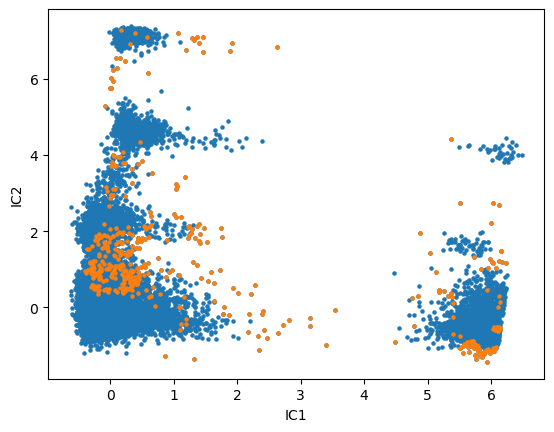

In [20]:
df3 = pd.DataFrame(unique_frames)
plt.scatter(X[:,0],X[:,1],s=5)
plt.xlabel('IC1')
plt.ylabel('IC2')
plt.scatter(df3[0],df3[1],s=5)

##### Following code will extract the serial number of each selected frame.

In [25]:
frame_index = []
for i in range(len(unique_frames)):
    target_ic1 =  unique_frames[i][0]
    target_ic2 =  unique_frames[i][1]
    distances = np.sqrt(
    np.square(tica_concatenated[:, 0] - target_ic1) +
    np.square(tica_concatenated[:, 1] - target_ic2)
    )
    frame_index.append(np.argmin(distances))

In [21]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=5, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[246]: Sampling MSMs:   0%|                      | 0/100 [00:00<…

fraction of states used = 1.00
fraction of counts used = 1.00


##### This will extract the enegy values. These energy values are used for raniking the data points. We are arranging the selected data points in ascending order based on energy values.

In [26]:
weights=np.concatenate(msm.trajectory_weights())
df4 = pd.DataFrame(weights)
energy = []
for i in frame_index:
    energy.append(weights[i])

In [28]:
d = {'frame_index': frame_index, 'energy': energy}
df5 = pd.DataFrame(d)
sorted_df = df5.sort_values(by='energy')
sorted_df = sorted_df.reset_index(drop=True)

In [22]:
len(sorted_df['frame_index'])

562

##### Here we can observe that from the initial 1,25,025 frames/structures, 562 structures has been selected to start the new simulation and explore the conformational space. 

In [29]:
idx = sorted_df['frame_index']
desired_num = 5
desired_frame= idx[0:desired_num]

##### Load the trajectory file. Note that files and pdb are initialized earlier. 

In [32]:
trajectory = md.load(files, top=pdb) 

#### Following code will generate pdb files and be saved into the current working directory.  

In [25]:
for i in desired_frame:
    extracted_frame = trajectory[i]
    extracted_frame.save(f'pentapeptide{i}.pdb') #Change the name of file depending on your molecule, currently it is pentapeptide.